In [1]:
# !pip install lime

In [2]:
# Initial imports
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics

from lime import lime_tabular

import psycopg2
import matplotlib. pyplot as plt 
import seaborn as sns

from collections import Counter
from config import password

In [3]:
# Load the pga data set dataset from database 
connection_string = f"host=red-team-final.c3yshvuxvm9x.us-east-2.rds.amazonaws.com dbname=red-team port=5432 user=postgres password={password}"
connection = psycopg2.connect(connection_string)

In [4]:
# Establish connection and db
sql = "select * from pga_stats"
pga_df = pd.read_sql(sql, connection)

In [5]:
# Show df
pga_df = pga_df.rename(columns={"money_MONEY":"Winnings"})
pga_df

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO,Winnings
0,1.144,2.099,321.1,66.80,51.47,0.696,66.67,80.34,80.87,50.25,...,48.89,61.27,0.435,41.01,3.27,1.752,28.74,14.54,1.84,5443091
1,0.841,1.700,307.1,64.01,29.17,0.582,72.11,85.90,83.80,57.32,...,50.00,63.07,-0.019,38.43,2.55,1.750,29.04,14.00,1.79,3556232
2,0.774,1.064,318.2,64.96,48.68,0.178,65.35,74.37,79.47,53.10,...,57.35,57.81,0.040,42.11,3.36,1.743,28.76,17.11,1.48,1782342
3,0.610,0.833,299.9,63.64,13.28,0.553,73.18,79.81,80.52,65.29,...,46.05,61.49,-0.013,37.67,2.52,1.756,29.30,12.50,1.91,1482028
4,0.567,0.563,287.4,60.36,8.33,-0.088,64.81,68.25,72.54,51.09,...,52.50,60.53,-0.793,39.12,2.78,1.779,29.25,15.74,1.15,164271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,-0.063,0.284,300.9,63.32,16.67,0.585,66.43,73.44,76.26,54.23,...,56.10,58.99,-0.113,36.55,3.22,1.807,29.45,16.26,1.17,824162
461,-0.417,-0.168,278.7,60.89,1.92,-0.006,63.53,68.20,73.63,48.14,...,54.17,62.30,0.451,42.02,1.42,1.748,28.32,15.03,1.27,942372
462,0.022,-0.402,285.1,62.05,1.69,-0.429,64.69,69.61,77.00,52.37,...,51.35,58.67,-0.006,38.51,2.73,1.779,29.15,16.95,1.14,332352
463,0.255,0.325,296.4,63.35,13.27,0.251,66.07,71.07,76.71,51.13,...,51.45,56.98,0.154,38.78,3.05,1.772,29.08,17.05,1.24,1943309


C:\Users\joela\anaconda3\envs\mlenv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


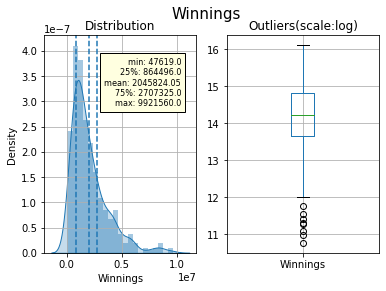

In [6]:
# Code form towarddatascience.com ammended for our own explanatory analysis

# Set variable
x = "Winnings"
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle(x, fontsize=15)

# Distribution
ax[0].title.set_text('Distribution')
var = pga_df[x].fillna(pga_df[x].mean())
breaks = np.quantile(var, q=np.linspace(0, 1, 11))
var = var[ (var > breaks[0]) & (var < 
                    breaks[10]) ]
sns.distplot(var, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = pga_df[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.9, 0.9, box, transform=ax[0].transAxes, fontsize=8, va='top', ha="right", bbox=dict(facecolor='lightyellow', alpha=1))

# Box plot 
ax[1].title.set_text('Outliers(scale:log)')
tmp_df = pd.DataFrame(pga_df[x])
tmp_df[x] = np.log(tmp_df[x])
tmp_df.boxplot(column=x, ax=ax[1])
plt.show()

In [7]:
# Define the features set as everything but money 
X = pga_df.drop("Winnings", axis=1)
X.head()

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,SG_ATG_AVERAGE,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO
0,1.144,2.099,321.1,66.80,51.47,0.696,66.67,80.34,80.87,50.25,...,0.259,48.89,61.27,0.435,41.01,3.27,1.752,28.74,14.54,1.84
1,0.841,1.700,307.1,64.01,29.17,0.582,72.11,85.90,83.80,57.32,...,0.326,50.00,63.07,-0.019,38.43,2.55,1.750,29.04,14.00,1.79
2,0.774,1.064,318.2,64.96,48.68,0.178,65.35,74.37,79.47,53.10,...,0.112,57.35,57.81,0.040,42.11,3.36,1.743,28.76,17.11,1.48
3,0.610,0.833,299.9,63.64,13.28,0.553,73.18,79.81,80.52,65.29,...,-0.329,46.05,61.49,-0.013,37.67,2.52,1.756,29.30,12.50,1.91
4,0.567,0.563,287.4,60.36,8.33,-0.088,64.81,68.25,72.54,51.09,...,0.084,52.50,60.53,-0.793,39.12,2.78,1.779,29.25,15.74,1.15


In [8]:
# Define the target set as Money/ Earning PGA
y = pga_df[["Winnings"]]
y.head()

,Winnings
0,5443091
1,3556232
2,1782342
3,1482028
4,164271


In [9]:
# See stats
X.describe()

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,SG_ATG_AVERAGE,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO
count,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,...,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000,465.000000
mean,0.098768,0.346110,296.352258,62.827849,14.570151,0.163426,66.595914,72.710043,77.570946,52.093462,...,0.083004,51.093075,59.746151,0.074660,39.514387,2.835398,1.760247,28.931742,15.828022,1.381376
std,0.356667,0.610017,8.522126,1.418809,9.723791,0.336851,2.470341,3.185690,2.812644,3.721184,...,0.211679,6.282326,3.333367,0.354373,2.203442,0.649185,0.027451,0.496314,1.719330,0.233647
min,-1.351000,-1.973000,272.600000,58.840000,0.000000,-0.643000,57.640000,61.470000,69.830000,40.100000,...,-0.437000,32.200000,49.260000,-1.159000,33.750000,1.390000,1.666000,27.500000,10.990000,0.750000
25%,-0.123000,-0.033000,290.400000,61.940000,7.320000,-0.072000,64.810000,70.610000,75.760000,49.880000,...,-0.062000,47.010000,57.610000,-0.152000,37.980000,2.360000,1.743000,28.580000,14.710000,1.240000
50%,0.094000,0.342000,296.300000,62.750000,12.180000,0.172000,66.670000,72.620000,77.780000,52.210000,...,0.071000,51.280000,59.900000,0.067000,39.520000,2.780000,1.762000,28.920000,15.720000,1.340000
75%,0.312000,0.739000,301.900000,63.660000,19.000000,0.408000,68.360000,74.760000,79.580000,54.170000,...,0.234000,55.560000,62.110000,0.336000,41.000000,3.270000,1.778000,29.280000,16.780000,1.500000
max,1.195000,2.126000,322.100000,67.880000,56.450000,1.051000,73.180000,85.900000,85.330000,65.290000,...,0.997000,68.550000,70.970000,1.101000,45.990000,4.860000,1.847000,30.360000,23.190000,2.360000


In [10]:
# Split Data into testing and training 
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(Counter(y_train))
print("X_train shape:", X_train.shape, "| X_test shape:", y_train.shape)
print("y_train mean:", round(np.mean(y_train),2), "| y_test mean:", round(np.mean(y_test),2))

Counter({'Winnings': 1})
X_train shape: (348, 22) | X_test shape: (348, 1)
y_train mean: Winnings    2152575.41
dtype: float64 | y_test mean: Winnings    1728307.19
dtype: float64


In [11]:
# Scale data
# Scale X
scalerX = StandardScaler()
X = scalerX.fit_transform(X_train)
df_scaled_X = pd.DataFrame(X, columns=X_train.columns, index=X_train.index)

# Scale Y
scaler_y = StandardScaler()
y = scaler_y.fit_transform(y_train)
df_scaled_y = pd.DataFrame(y, columns=y_train.columns, index=y_train.index)

In [12]:
# Make scaled df
df_scaled = df_scaled_X.join(df_scaled_y)
df_scaled

,SG_off_tee_AVERAGE,SG_tee_green_AVERAGE,driving_dist_AVG.,pct_ydg_tee_AVG (%),driving_320+_%,SG_approach_green_AVERAGE,GIR_pct_%,GOFIR_pct_%,GIR_pct_fwy_%,GIR_pct_not_fwy_%,...,pct_sand_save_%,scrambling_%,SG_putt_AVERAGE,pct_one_putt_%,pct_three_putt_avoid_%,putt_avg_AVG,putts_per_rd_AVG,bogey_avoid_% MAKES BOGEY,btb_ratio_BIRDIE TO BOGEY RATIO,Winnings
86,-1.931177,-2.531737,-2.371906,-2.694467,-1.348703,-1.770961,-1.532405,0.515783,-2.401297,-0.844176,...,-1.823939,0.051155,1.493997,0.600296,-0.495082,-0.973500,-1.824755,1.685954,-1.427770,-1.005542
131,0.467185,0.528140,-0.070779,0.492113,0.149546,-0.183932,-0.484788,-0.440125,0.504282,0.456156,...,1.510863,1.141377,1.526817,2.258257,-1.497408,-2.269601,-2.161098,-0.855554,1.249299,1.153132
28,0.338125,0.526589,0.364872,-0.074538,0.287950,-0.218876,0.055014,1.201210,0.580836,0.194437,...,0.878537,0.427297,-0.964465,-0.612384,0.236774,0.284481,-0.332235,-0.064741,-0.068643,-0.494071
52,-0.334061,-0.941284,-0.260678,0.012126,-0.340192,-0.894455,-0.500782,0.119281,-0.146429,-1.114160,...,0.436863,0.659446,-0.385652,0.552926,0.411784,-0.211087,-0.542449,0.077060,-0.151014,-0.896672
124,0.163357,-0.385789,0.599452,1.165428,0.519268,0.212098,-0.364832,-0.778228,0.333775,0.957556,...,0.314528,-0.010555,-0.842139,0.841885,1.270920,-0.363570,-0.311214,0.720617,-0.192200,-0.059821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,1.209279,0.191430,1.135637,1.032099,1.396150,-0.448922,0.586820,0.070102,0.159788,0.649002,...,0.476582,-0.648232,0.939053,0.121856,0.411784,-0.058605,0.319429,0.126144,-0.192200,1.187556
408,0.658086,1.636027,0.096779,-0.594524,0.024692,2.253396,1.410518,0.561888,0.608674,1.150401,...,-1.876368,1.282430,0.136473,-0.631332,-0.272343,0.131998,0.235343,-1.493658,1.208113,0.964514
188,2.932766,2.747017,1.884062,1.978740,2.014613,1.362330,0.806739,1.822090,0.274619,0.172398,...,0.673587,1.064974,1.007675,1.287165,-1.624687,-2.231480,-1.131049,-1.859068,2.896725,3.096690
208,-0.570671,-0.021148,0.029756,-0.374530,-0.346967,0.471264,1.250577,0.712498,0.333775,2.304722,...,0.563963,0.403788,0.348306,0.268704,-0.001874,-0.592294,-0.016914,-1.035532,1.125742,-0.606653


<AxesSubplot:title={'center':'pearson correlation'}>

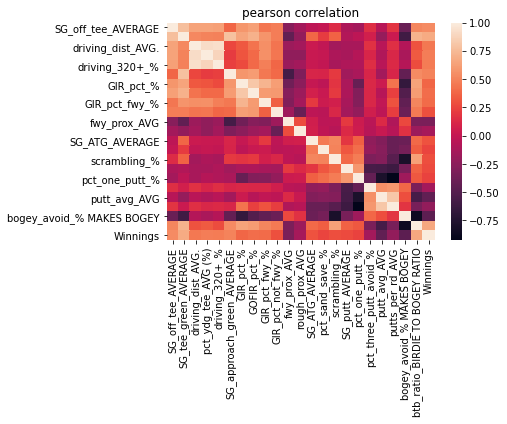

In [13]:
# Show correlation matrix
# Learned about pearson method from towarddatascience
c_matrix = df_scaled.corr(method="pearson")
plt.title("pearson correlation")
sns.heatmap(c_matrix)

In [14]:
# # Prep data 
# # Prep X-train data
# Xt = pd.DataFrame(X)
# Xt.columns = X_train.columns

# # Prep y-train data
# yt = pd.DataFrame(y)
# yt.columns = y_train.columns

In [15]:
# Call Linear Regression model
model = linear_model.LinearRegression()

# Train data to model 
model.fit(X, y)

LinearRegression()

In [16]:
# Predict
y_pred = model.predict(X_test)
y_pred

array([[-128.62260218],
       [-128.08807022],
       [-129.05279201],
       [-130.44215583],
       [-132.89232353],
       [-133.86869824],
       [-129.45086705],
       [-128.0355852 ],
       [-128.02835146],
       [-126.97669045],
       [-130.9581363 ],
       [-129.42314764],
       [-130.74478153],
       [-131.39121004],
       [-128.81737002],
       [-125.62322339],
       [-131.11671267],
       [-127.67313791],
       [-128.52286217],
       [-124.52182413],
       [-131.39282295],
       [-127.06247556],
       [-127.27003158],
       [-127.25795988],
       [-129.29762561],
       [-128.59104104],
       [-132.41181628],
       [-129.10444338],
       [-128.65922337],
       [-127.36164271],
       [-131.61656215],
       [-127.44004775],
       [-128.79338873],
       [-130.51188289],
       [-124.49373817],
       [-126.21404072],
       [-125.61146469],
       [-128.08904985],
       [-132.9305633 ],
       [-129.83512844],
       [-125.88058085],
       [-127.742

In [17]:
# "Unscale"
predicted = scaler_y.inverse_transform(y_pred.reshape(-1,1)).reshape(-1)
predicted

array([-2.31804904e+08, -2.30832619e+08, -2.32587395e+08, -2.35114572e+08,
       -2.39571293e+08, -2.41347266e+08, -2.33311472e+08, -2.30737152e+08,
       -2.30723994e+08, -2.28811080e+08, -2.36053113e+08, -2.33261052e+08,
       -2.35665032e+08, -2.36840850e+08, -2.32159176e+08, -2.26349198e+08,
       -2.36341554e+08, -2.30077880e+08, -2.31623482e+08, -2.24345813e+08,
       -2.36843784e+08, -2.28967119e+08, -2.29344652e+08, -2.29322694e+08,
       -2.33032734e+08, -2.31747496e+08, -2.38697277e+08, -2.32681347e+08,
       -2.31871516e+08, -2.29511287e+08, -2.37250753e+08, -2.29653902e+08,
       -2.32115555e+08, -2.35241402e+08, -2.24294726e+08, -2.27423862e+08,
       -2.26327809e+08, -2.30834401e+08, -2.39640849e+08, -2.34010423e+08,
       -2.26817317e+08, -2.30203197e+08, -2.27940396e+08, -2.28053004e+08,
       -2.35472509e+08, -2.23631501e+08, -2.31754029e+08, -2.29622520e+08,
       -2.34804063e+08, -2.32142554e+08, -2.24603082e+08, -2.29384699e+08,
       -2.28649931e+08, -